# Exercise 04 ANN for Regression - Instruction

## Pedagogy

This notebook serves as an instruction for implementing an artificial neural network using Pytorch to develop a regression model.

Please use this notebook as a reference and tutorial for completing the assignment.

### Pre-configure

In [95]:
# import libraries
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [96]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [97]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Part 1. Implement an ANN as a linear regression model

### Step 1. Build the data pipeline

Training an artificial neural network is an iterative process.

We need to feed a **batch** of training samples to the network at each iteration, make predictions, compute loss and gradients, and update learning parameters accordingly.

In practice, the whole training set is divided into several batches. The number of batches depends on the batch size and the size of training set. Once all batches are fed to the network, we say an **epoch** is completed.

Training a network for one epoch is usually not enough. Therefore, we need to go through the training sets repeatedly for many epoches to get a well-fitted model.

That's why we need to build a data pipeline that can continuously and iteratively feed batches of taining samples to the network.

`PyTorch` has two high-level APIs to work with data:
- `torch.utils.data.Dataset`
- `torch.utils.data.DataLoader`

`torch.utils.data.Dataset` stores the samples and their corresponding lables.
`torch.utils.data.DataLoader` wraps an iterable object based on the `torch.utils.data.Dataset`.

For this notebook, we will use a toy dataset, the diabetes dataset, from `sklearn`. You can find more details about this dataset at this [link](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html).

As the diabetes dataset is a tabular dataset that consists of numerical feature and target variables, we can use `torch.utils.data.TensorDataset`, a custom class that inherits from the `torch.utils.data.Dataset` class, to store the samples.

In this step, we need to:
1. Load the diabetes dataset
2. Divide the dataset into the training and test set
3. Create a `TensorDataset` instance to store the training/test set
4. Create a `DataLoader` instance to wrap the training/test set as an iterable object

In [98]:
# load diabetes dataset
feature, label = datasets.load_diabetes(
    return_X_y = True,
    as_frame = False, # get data as numpy array
    scaled = True # ANN requires to scale the input features
)
# train test split
train_feature, test_feature, train_label, test_label = train_test_split(
    feature,
    label,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

In [99]:
# create the train and test dataset
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [100]:
# create the train and test data loaders ### PLAY WITH BATCH SIZE ###
batch_size = 64 # usually set to 2 to the nth power, recomendation to choose as big as possible
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)
# shuffle = True means the data is reshuffled at every epoch
# recommend to reshuffle training data
# don't reshuffle test data since test data will be fed to network only once
# we may also need to keep the order of test samples in the test set

In [101]:
# get a minibatch from the data loader and print shape of feature and label
for (X, y) in train_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 10])
torch.Size([64])


We can see the feature batch has two dimensions:
- 1st dimension is the batch size
- 2nd dimension is the number of features

The label batch has only one dimention, which is the batch size. This is because we only have one target variable as the label to predict. If there are multiple target variables to predice using the single network, the label batch will also have two dimensions.

### Step 2. Create the artificial neural network

To define a neural network in `PyTorch`, we create a class that inherits from `torch.nn.Module`.

We need to define the layers of the network in the `__init__()` method and specify how data will pass through the network in the `forward()` method.

In [10]:
# define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Linear(n_features, n_labels)
    def forward(self, X):
        return self.net(X)

We can see we defined a simple network with only one layer. The input size of this layer is the number of feature variables, the output size is the number of target variables. We didn't add any operation to represent activation function, which indicates the activation function is linear.

This is how we create an artificial neural network that is equivalent to a linear regression model.

Read the `PyTorch` documentation:
- `torch.nn.Linear()` at this [link](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

Create a class to define the ANN is not enough. We also need to create an instance of the class, in other words, initialize the ANN.

And we also need to move the network to the computation device, the network is on CPU by default. If we want to use GPU for acceleration, we need to move the network from CPU to GPU, as well as the data.

In [16]:
# initialize the neural network
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
# move the model to the computation device
model.to(device)

NeuralNetwork(
  (net): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
# print network structure and learning parameters
print(f"Model structure:\n{model}\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Model structure:
NeuralNetwork(
  (net): Linear(in_features=10, out_features=1, bias=True)
)

Layer: net.weight | Size: torch.Size([1, 10])
Layer: net.bias | Size: torch.Size([1])


### Step 3. Training by gradient descent

To train a neural network, we need:
- A data loader of the training set (batch size)
- A loss function
- An optimizer (learning rate)
- The number of epoches to train

We can define a `train()` function that takes the above elements as parameters and performs the training process.

In a single training loop, the neural network makes predictions on the training samples (fed to it in batches), and backpropagates the prediction error to adjust the learning parameters. It's also good to record the changes in loss for further analysis and adjustment.

Let's defind a `train()` function to implement this process.

In [18]:
# define the training function
def train(dataloader, model, loss_fn, optimizer, epochs):
    batch_loss_history = [] # for recording the average loss of a batch
    epoch_loss_history = [] # for recording the average loss of an epoch
    model.train() # set the model in training mode
    for epoch in range(epochs): # iterate pre-defined number of epoches
        epoch_loss = 0.0 # initial epoch loss is set to zero
        for (X, y) in dataloader: # get a batch of training samples
            X, y = X.to(device), y.to(device) # move data to the computation device
            pred = model(X).squeeze() # make predictions, squeeze() reduce `pred` to 1D tensor
            batch_loss = loss_fn(pred, y) # compute the current batch loss
            batch_loss.backward() # compute gradients by backpropagation
            optimizer.step() # update learning parameters according to gradients
            optimizer.zero_grad() # reset the gradients to zero
            batch_loss_history.append(batch_loss.item()) # record current batch loss
            epoch_loss += batch_loss.item() # accumulate batch losses for compute epoch loss
        epoch_loss /= len(dataloader) # compute current epoch loss
        epoch_loss_history.append(epoch_loss) # record current epoch loss
        print(f"Epoch {epoch + 1}: train loss = {epoch_loss}") # print log
    return batch_loss_history, epoch_loss_history

After define the `train()` function, we need to specify the loss function, learning rate, optimizer, and number of epoches before training.

When specifying the optimizer, we should also specify the parameters to optimize, which is the first argument of the optimizer.

In [19]:
# define the training hyper-parameters #### PLAY WITH THESE PARAMETERS ####
loss_fn = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # you should use the name of your network for the first argument
epochs = 1000

In [20]:
# train the neural network
batch_loss_history, epoch_loss_history = train(train_dl, model, loss_fn, optimizer, epochs)

Epoch 1: train loss = 22104.73928222656
Epoch 2: train loss = 13173.431552124024
Epoch 3: train loss = 9537.212158203125
Epoch 4: train loss = 7804.739404296875
Epoch 5: train loss = 6789.431530761719
Epoch 6: train loss = 6601.319787597657
Epoch 7: train loss = 6228.864660644531
Epoch 8: train loss = 6077.894403076172
Epoch 9: train loss = 6262.899731445313
Epoch 10: train loss = 6046.704309082032
Epoch 11: train loss = 6217.755517578125
Epoch 12: train loss = 5988.497802734375
Epoch 13: train loss = 6111.222497558594
Epoch 14: train loss = 6074.61044921875
Epoch 15: train loss = 6221.569030761719
Epoch 16: train loss = 6073.4234619140625
Epoch 17: train loss = 5876.610754394531
Epoch 18: train loss = 6069.856640625
Epoch 19: train loss = 5836.182348632812
Epoch 20: train loss = 6056.199755859375
Epoch 21: train loss = 5922.235681152344
Epoch 22: train loss = 5838.205090332031
Epoch 23: train loss = 5779.545275878906
Epoch 24: train loss = 5790.548547363282
Epoch 25: train loss = 5785

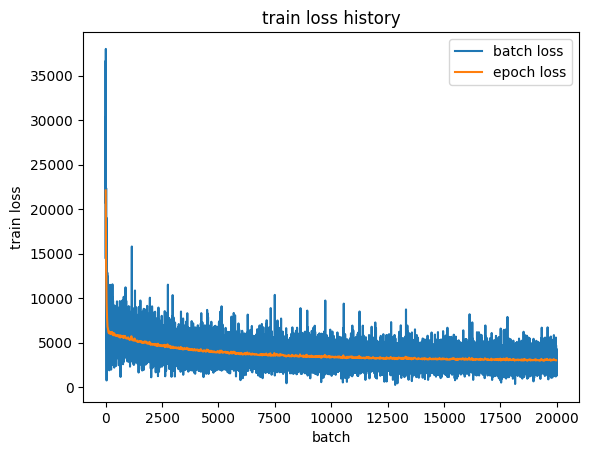

In [21]:
# plot the train loss history
plt.figure()
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

The loss is gradually reduced by mini-batch gradient descent.

Due to the randomness in selecting training samples for each batch, we can find that although the batch loss shows a decreasing trend, it still fluctuates significantly.

However, we can't find such significant fluctuation of the epoch loss. This also proves the effectiveness of mini-batch gradient descent method.

### Step 4. Save and load a trained model

Training a neural network oftern takes a lot of time. We don't want to retrain every time we use it.

A better approach is to save the trained model after training is completed.

When we need to use the model in the future, we can load it from the saved file.

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [22]:
# save model
file_name = 'model.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to '+ file_name)

Saved PyTorch Model State to model.pth


The process for loading a model includes re-initializing the network and loading the state dictionary (containing the model parameters) into it.

In [23]:
# load model
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
model.load_state_dict(torch.load(file_name))

/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_1804/1337914836.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


<All keys matched successfully>

The `<All keys matched successfully>` means we successfully loaded the trained model to the newly created neural network.

If the structure of the newly created network is different from the structure of the trained model, we will get an error.

In [24]:
# move model to the computation device
model.to(device)

NeuralNetwork(
  (net): Linear(in_features=10, out_features=1, bias=True)
)

### Step 5. Make predictions and evaluation

The loss value on the training set can only represent the fitness of the neural network to the training data. We also need to ensure the trained network generalize well on unseen data.

Therefore, we need to make predictions on the test set and evaluation the generalization ability.

We can feed the entire test set to the network to make predictions. Or we can do it in batch. It's better to do it in batch since we may deal with very big dataset, feeding the entire test set to the network may exceed the available memory of your computer.

To do that in batch, we can define a `test()` function, which is similar to the `train` function but much simpler.

In [25]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_pred_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0 # set initial test loss to zero
        for (X, y) in dataloader: # get a batch from test samples
            X, y = X.to(device), y.to(device) # move data to the computation device
            batch_pred = model(X).squeeze() # make predictions, squeeze() reduce `batch_pred` to 1D tensor
            batch_loss = loss_fn(batch_pred, y) # compute current batch loss
            loss += batch_loss.item() # accumulate batch losses for compute test loss
            batch_pred_list.append(batch_pred.cpu().numpy()) # move the batch predictions back to CPU and record
        loss /= len(dataloader) # compute test loss
        pred = np.concatenate(batch_pred_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return pred, loss

In [26]:
# make prediction on test set and evaluate the performance
test_pred, test_loss = test(test_dl, model, loss_fn)

test loss = 3068.465630425347


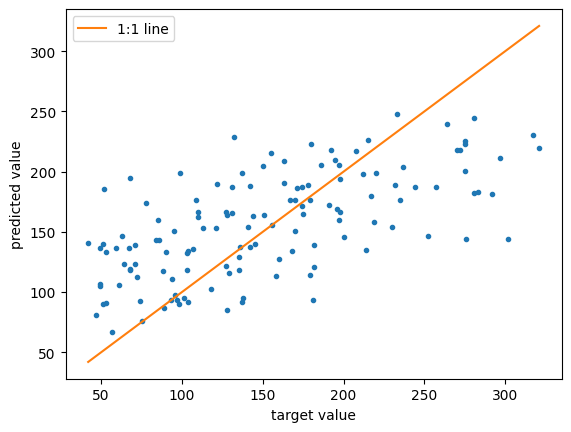

In [27]:
# plot the prediction results of the test dataset
plt.figure()
plt.plot(test_label, test_pred, '.')
plt.plot([min(test_label), max(test_label)], [min(test_label), max(test_label)], '-', label = '1:1 line')
plt.xlabel('target value')
plt.ylabel('predicted value')
plt.legend()
plt.show()

In [28]:
# calculate the evaluation metrics of the test dataset
print('RMSE =', root_mean_squared_error(test_label, test_pred))
print('R2 =', r2_score(test_label, test_pred))

RMSE = 55.24787209863334
R2 = 0.4016794088346125


## Part 2. Implement a multi-layer ANN for regression

We already implement our 1st one-layer ANN as a linear regression model.
- There are only one input layer and one output layer in the network
- The number of input neurons in the input layer is equal to the number of input features
- The number of output neurons is 1, which is equal to the number of target variables to predict
- The activation function is somehow ignored, which indicates the output neuron adopts the linear activation function: $f(z)=z$.

Therefore, the output of this one-layer ANN is $\hat{y}=w_1x_1+w_2x_2+...+w_nx_n+b$, the same as a linear regression model.

However, we already knew that such model might not be complex enough to learn the hidden patterns in the dataset and to solve complex regression problems.

### Option 1. Increase the capacity of the ANN

In the context of ANN, the capacity of an one-layer ANN might be too small for a complex regression model. We can increase this capacity by constructing a multi-layer ANN, which stacks multiple layers in sequence to form a deeper ANN with larger capacity.

To do that, we need to be careful of:
- The input size of the first layer is equal to the number of features
- The input size of a layer is equal to the output size of the previous layer
- If we have multiple layers stacked together, we can create an ordered container of layers using `torch.nn.Sequential`.

In [128]:
# define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential( # Play with the number of hidden layers and neurons.
            nn.Linear(n_features, 32), # There is not a rule to choose the number of neurons in the hidden layer
            nn.Linear(32, 64), # Number of neurons in the hidden layer
            nn.Linear(64, 32), # Number of neurons in the hidden layer
            nn.Linear(32, 16),
            nn.Linear(16, 8),
            nn.Linear(8, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [129]:
# initialize the neural network
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
# move the model to the computation device
model.to(device)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [130]:
# define the training hyper-parameters #### PLAY WITH THESE PARAMETERS ####
loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # you should use the name of your network for the first argument
epochs = 1500

In [131]:
# train the neural network
batch_loss_history, epoch_loss_history = train(train_dl, model, loss_fn, optimizer, epochs)

Epoch 1: train loss = 29514.307421875
Epoch 2: train loss = 29347.69921875
Epoch 3: train loss = 29323.298046875
Epoch 4: train loss = 28773.1125
Epoch 5: train loss = 28768.208984375
Epoch 6: train loss = 27932.507421875
Epoch 7: train loss = 21605.74501953125
Epoch 8: train loss = 21148.21640625
Epoch 9: train loss = 26225.35390625
Epoch 10: train loss = 27358.179296875
Epoch 11: train loss = 17715.075
Epoch 12: train loss = 28346.810546875
Epoch 13: train loss = 27752.504296875
Epoch 14: train loss = 24615.694140625
Epoch 15: train loss = 10696.4658203125
Epoch 16: train loss = 17656.0830078125
Epoch 17: train loss = 8220.97412109375
Epoch 18: train loss = 6062.00244140625
Epoch 19: train loss = 7338.1099609375
Epoch 20: train loss = 6487.5025390625
Epoch 21: train loss = 8663.816796875
Epoch 22: train loss = 8493.9259765625
Epoch 23: train loss = 5958.5337890625
Epoch 24: train loss = 6266.80849609375
Epoch 25: train loss = 10165.4884765625
Epoch 26: train loss = 6586.93251953125
E

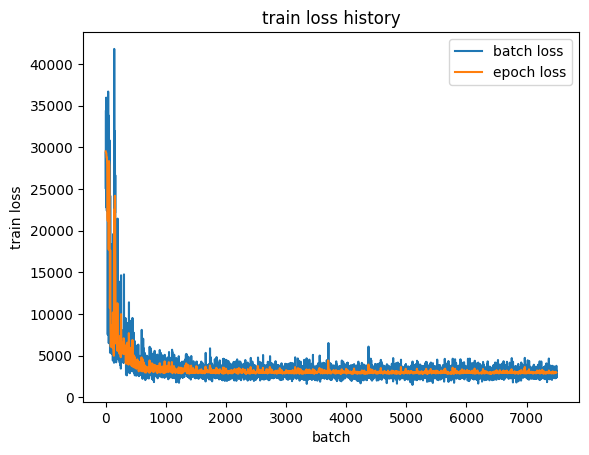

In [132]:
# plot the train loss history
plt.figure()
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

In [126]:
test_pred, test_loss = test(test_dl, model, loss_fn)

test loss = 3234.5839029947915


In [127]:
# calculate the evaluation metrics of the test dataset
print('RMSE =', root_mean_squared_error(test_label, test_pred))
print('R2 =', r2_score(test_label, test_pred))

RMSE = 55.37776744142399
R2 = 0.39886263347556683


We defined a 4-layer network with linear activation functions.

The `forward()` function remains the same. This is becaues we embedded multiple `nn.Linear()` layers into one `nn.Sequential()` container, which can be treated as a whole in forward propagation.

Read the `PyTorch` documentation:
- `torch.nn.Sequential()` at this [link](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential).

This is how we can increase the capacity of the ANN by adding more layers in the network.

<span style="color:red">Now use this multi-layer ANN to build a regression model using the same dataset and steps in Part 1.</span>
- Can you increase model's performance comparing with the one-layer ANN?
- Try to change the batch size, learning rate, number of layers and neurons to achieve a good performance without increasing the capacity too much.
- If you get a loss value of `nan`, this is because the loss value exceeds the range that can be expressed by a `float32` object.
    - This is what we called gradient explosion
    - You can try to decrease the learning rate

### Option 2. Add non-linearity in ANN

No matter how many hidden layers and neurons we add to the network, the output is sill the linear combination of the input features, which can only represent the linear relationship between the feature vairables and the target variable.

To add non-linearity in the network, we can change the activation function from a linear one to a non-linear one. To do that:
- We can add activation function as a separate layer following the corresponding layer, for example, a `torch.nn.ReLU()` follows a `torch.nn.Linear()`
- Or we can embed the activation function into the `forward()` function, we will not show this way in this notebook.

The most popular non-linear activation functions are:
- ReLU, `torch.nn.ReLU()`, see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU).
- Tanh, `torch.nn.Tanh()`, see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh).
- Sigmoid, `torch.nn.Sigmoid()`, see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid).

You can find all the pre-defined types of layers and activation function in PyTorch at this [link](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

These pre-defined layers and activation functions give us the great flexibility in the structure of the ANN.

Now let's introduce the non-linearity to the ANN by adding non-linear activation function layers.

In [140]:
# define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [161]:
# initialize the neural network
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
# move the model to the computation device
model.to(device)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [162]:
# define the training hyper-parameters #### PLAY WITH THESE PARAMETERS ####
loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # you should use the name of your network for the first argument
epochs = 1000

In [163]:
# train the neural network
batch_loss_history, epoch_loss_history = train(train_dl, model, loss_fn, optimizer, epochs)

Epoch 1: train loss = 29123.602734375
Epoch 2: train loss = 29054.403125
Epoch 3: train loss = 29111.59375
Epoch 4: train loss = 28963.449609375
Epoch 5: train loss = 28830.33359375
Epoch 6: train loss = 28678.3796875
Epoch 7: train loss = 28165.271875
Epoch 8: train loss = 27385.04140625
Epoch 9: train loss = 25920.769140625
Epoch 10: train loss = 20182.73984375
Epoch 11: train loss = 7289.3908203125
Epoch 12: train loss = 6461.140234375
Epoch 13: train loss = 6324.09091796875
Epoch 14: train loss = 5972.71103515625
Epoch 15: train loss = 6289.5146484375
Epoch 16: train loss = 5882.35693359375
Epoch 17: train loss = 5951.35205078125
Epoch 18: train loss = 5969.9361328125
Epoch 19: train loss = 5841.42490234375
Epoch 20: train loss = 5585.3203125
Epoch 21: train loss = 5316.737109375
Epoch 22: train loss = 5332.46123046875
Epoch 23: train loss = 5270.2578125
Epoch 24: train loss = 4937.2583984375
Epoch 25: train loss = 4750.897119140625
Epoch 26: train loss = 4669.69921875
Epoch 27: tr

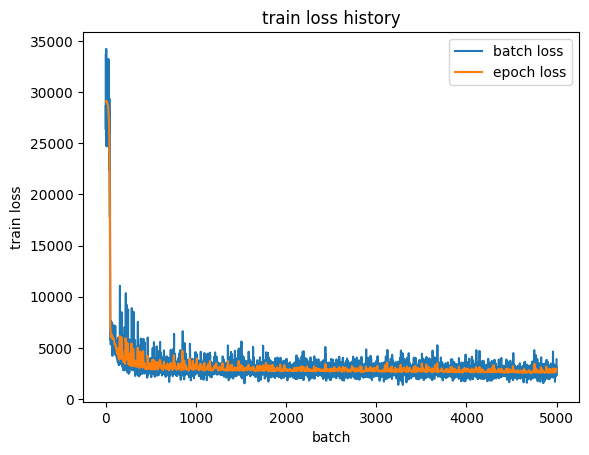

In [164]:
# plot the train loss history
plt.figure()
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

In [165]:
test_pred, test_loss = test(test_dl, model, loss_fn)

test loss = 3358.0476888020835


In [166]:
# calculate the evaluation metrics of the test dataset
print('RMSE =', root_mean_squared_error(test_label, test_pred))
print('R2 =', r2_score(test_label, test_pred))

RMSE = 54.81175148744773
R2 = 0.41108827894905897


We add the ReLU activation function for the three hidden layers in the network.

Note that, we usually don't add any non-linear activation function for the output layer.

<span style="color:red">Now use this non-linear ANN to build a regression model using the same dataset and steps in Part 1.</span>
- Can you increase model's performance comparing with the linear ANN?
- Try to change the activation functions and also other hyper-parameters to achieve a good performance.
    - If your network always predict the average value of the target variables, it means the capacity of the network is not enough to capture the non-linear relationship, try to increase the capacity.
    - If the train loss is much lower than the test loss, it means your network is over-fitted. Try to decrease the capacity.

We often refer to the training process of deep learning as alchemy because there are so many hyperparameters that we can adjust.

We will learn more techniques in later lessons to ensure that our models are not overfitting or underfitting. But experience is still extremely important.

Try as many different combinations of training hyperparameters as possible, gain experience by observing the problems you encounter and solving them by adjusting the hyperparameters.